In [3]:
import numpy as np
import pandas as pd
import joblib
import rasterio
from rasterio.crs import CRS
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

model_path = "../../models/SG_15_30_models/brtmodel.joblib.pkl"
brt = joblib.load(model_path)
image = rasterio.open(fr'C:\Users\admin\OneDrive\Computing\Yr5 Advanced Computing\MAC Project\Carbon-Trading-Verification\scotland_carbon\data\S1A_S2AL2A_INDICES_DEM_EVAL.tif')

num_bands = image.count
img_width = image.width
img_height = image.height
num_pixels = img_height * img_width
all_data = []
print("Image shape:", image.shape)



Image shape: (132, 194)


In [4]:
print("Converting Raster to Array...")
for i in tqdm(range(num_bands)):
    data = image.read(i+1)
    data = pd.DataFrame(data).fillna(0).to_numpy()
    all_data.append(data)

all_data = np.dstack(all_data)
all_data_shape = all_data.shape
print("Raster array shape:", all_data_shape)




100%|████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 749.97it/s]

Converting Raster to Array...
Raster array shape: (132, 194, 18)


In [5]:
print("Calculating SOC...")
result_data = []
non_zero = 0
for t in tqdm(all_data):
    z = brt.predict(t)
    result_data.append(z)
    non_zero += np.count_nonzero(z)
    z[z!=z] = 0
    # print(torch.min(z), torch.max(z))
print("non_zero:", non_zero)

# result_data = np.exp(np.stack(result_data))
result_data = np.stack(result_data)

# Transform result_data for display
print(result_data)
result_data = np.exp(result_data)

# x_pos, x_label = 
# y_pos, y_label = 



# with rasterio.open(
#     '../../out/brt_map.tif',
#     'w',
#     driver='GTiff',
#     height=result_data.shape[0],
#     width=result_data.shape[1],
#     count=1,
#     dtype=result_data.dtype,
#     crs=CRS.from_epsg(27700),
#     transform=image.transform,
# ) as dst:
#     dst.write(result_data, 1)

 11%|██████▎                                                | 15/132 [00:00<00:00, 141.51it/s]

Calculating SOC...


100%|██████████████████████████████████████████████████████| 132/132 [00:00<00:00, 153.13it/s]

non_zero: 25608
[[ 6.56532416  6.55215829  6.5221361  ...  6.53714021  6.4367723
   3.60146951]
 [ 6.46130985  6.48119284  6.20943418 ...  6.4615259   6.4718544
   3.80322206]
 [ 6.54393064  6.53767343  6.48031321 ...  6.32257377  6.47906511
   2.66981419]
 ...
 [ 7.24056302  7.07364284  7.14550198 ...  6.22690546  6.35137385
   3.57726545]
 [ 7.39687494  7.27660415  7.41511138 ...  4.96747413  6.27755847
   3.68855662]
 [ 1.10404002  1.50766046  1.5622986  ...  3.7501908   1.99408228
  -1.34876114]]


In [102]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

def plot_graph(result_data, err_data, title, map_style, file_name):

    fontprops = fm.FontProperties(size=12)
    # https://epsg.io/transform#s_srs=27700&t_srs=4326&x=293167.0000000&y=652518.0000000
    # topleft - x = -3°42.2263', y = 55°45.25162'
    # x = -3.7037717°, y = 55.7541937°
    # bottomright - x = -2.7696528°, y = 55.4075244°
    x_coord_l, x_coord_r = -3.7037717, -2.7696528
    y_coord_t, y_coord_b = 55.7541937, 55.4075244
    x_shape = result_data.shape[1]
    y_shape = result_data.shape[0]

    def x_format_func(value, tick_number):
        out = (x_coord_l + (value / x_shape * (x_coord_r - x_coord_l)))
        return "{v:.2f}\N{DEGREE SIGN}".format(v=out)

    def y_format_func(value, tick_number):
        out = (y_coord_t - (value / y_shape * (y_coord_t - y_coord_b)))
        return "{v:.2f}\N{DEGREE SIGN}".format(v=out)

    ###################################################################################
    gridspec = {'width_ratios': [1, 1, 0.1]}
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(9, 4), gridspec_kw=gridspec)
    fig.suptitle(title)
    
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(x_format_func))
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(x_format_func))
    ax1.xaxis.set_major_locator(plt.MaxNLocator(7))
    ax2.xaxis.set_major_locator(plt.MaxNLocator(7))
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(y_format_func))

    scalebar1 = AnchoredSizeBar(ax1.transData,
                               33.3, '10 km', 'lower right', 
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)
    
    scalebar2 = AnchoredSizeBar(ax2.transData,
                               33.3, '10 km', 'lower right', 
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)

    ax1.add_artist(scalebar1)
    ax2.add_artist(scalebar2)
    ax1.set_title('Prediction Map', size=10)
    ax2.set_title('Error Map', size=10)
    

    pred_plot = ax1.imshow(result_data, cmap = map_style)
    ax2.imshow(result_data, cmap = map_style)
    
    ax2.get_yaxis().set_visible(False)
    
#     plt.xlabel("Latitude")
#     plt.ylabel("Londgitude")
    fig.text(0.5, 0.12, 'Longitude', ha='center')
    fig.text(0.04, 0.5, 'Latitude', va='center', rotation='vertical')
#     plt.colorbar(pred_plot, label="Amount of Soil Organic Carbon (Mg C/ha)")
    
    cbar = plt.colorbar(pred_plot, cax=ax3)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Amount of carbon (Mg C/ha)', rotation=270, size=9)
    
#     plt.savefig(file_name)
    plt.show()
    
    


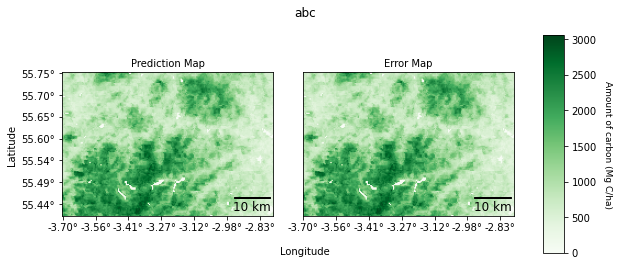

In [104]:
image = rasterio.open(fr'C:\Users\admin\OneDrive\Computing\Yr5 Advanced Computing\MAC Project\Carbon-Trading-Verification\scotland_carbon\data\Train_SG_15-30_27700_clipped.tif')
data = image.read(1)
# pred, error, title, output directory
plot_graph(data, np.abs(data-result_data[:131, :193]), 'abc', 'Greens', '../../report_output/experiment1/brt_truth.png')

In [105]:
# Archive Code

<Figure size 432x288 with 0 Axes>

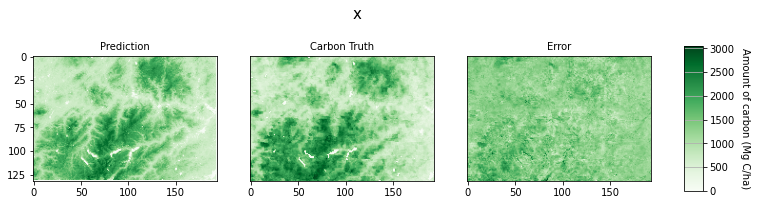

In [27]:
# model = agb
soc_truth = rasterio.open(fr'C:\Users\admin\OneDrive\Computing\Yr5 Advanced Computing\MAC Project\Carbon-Trading-Verification\scotland_carbon\data\Train_SG_15-30_27700_clipped.tif').read(1)






fontprops = fm.FontProperties(size=12)
# https://epsg.io/transform#s_srs=27700&t_srs=4326&x=293167.0000000&y=652518.0000000
# topleft - x = -3°42.2263', y = 55°45.25162'
# x = -3.7037717°, y = 55.7541937°
# bottomright - x = -2.7696528°, y = 55.4075244°
x_coord_l, x_coord_r = -3.7037717, -2.7696528
y_coord_t, y_coord_b = 55.7541937, 55.4075244
x_shape = result_data.shape[1]
y_shape = result_data.shape[0]

def x_format_func(value, tick_number):
    out = (x_coord_l + (value / x_shape * (x_coord_r - x_coord_l)))
    return "{v:.2f}\N{DEGREE SIGN}".format(v=out)

def y_format_func(value, tick_number):
    out = (y_coord_t - (value / y_shape * (y_coord_t - y_coord_b)))
    return "{v:.2f}\N{DEGREE SIGN}".format(v=out)

###################################################################################
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')

ax1.xaxis.set_major_formatter(plt.FuncFormatter(x_format_func))
ax2.xaxis.set_major_formatter(plt.FuncFormatter(x_format_func))
# ax.xaxis.set_major_locator(plt.MaxNLocator(7))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(y_format_func))
# ax.yaxis.set_major_locator(plt.MaxNLocator(4))

scalebar1 = AnchoredSizeBar(ax1.transData,
                           33.3, '10 km', 'lower right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

scalebar2 = AnchoredSizeBar(ax2.transData,
                           33.3, '10 km', 'lower right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

ax1.add_artist(scalebar1)

ax2.add_artist(scalebar2)





carbon_map = plt.figure(3)
gridspec = {'width_ratios': [1, 1, 1, 0.1]}
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(10, 3), gridspec_kw=gridspec)

plt.suptitle("x", size=15)

pred_plot = ax1.imshow(result_data, cmap = 'Greens')
ax1.set_title('Model Prediction', size=10)

plt.rcParams["axes.grid"] = False
error_plot = ax3.imshow(soc_truth-result_data[:131, :193], cmap='Greens')
ax3.set_title('Error Map', size=10)
ax3.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(True)
carbon_plot = ax2.imshow(soc_truth, cmap='Greens')
ax2.set_title('Ground Truth Map', size=10)
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(True)
plt.rcParams["axes.grid"] = False
plt.tight_layout()
plt.subplots_adjust(top=0.8)

plt.rcParams["axes.grid"] = False
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
# divider = make_axes_locatable(ax4)
cax = ax4
cbar = plt.colorbar(carbon_plot, cax=cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Amount of carbon (Mg C/ha)', rotation=270, size=10)
ax4.grid(True)
carbon_map.patch.set_facecolor('white')
#     plt.savefig(filename, bbox_inches = 'tight')
plt.show()
plt.close()